In [26]:
from okx.api import Account
from okx.api import Trade
from okx_api import Market as Market_api
import os
import time
import math
from dotenv import load_dotenv
from okx.app import OkxSPOT
load_dotenv()
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [27]:
market = Market_api(key = '', secret = '', passphrase = '', flag = '0')
okxSPOT = OkxSPOT(
    key = "",
    secret = "",
    passphrase = "",
)

In [28]:
full_data = pd.DataFrame(columns = ['open', 'high', 'low', 'close'])

def History_finder(y, m, full_data):
    
    month = f"{y}-{m}-1"
    time_before = datetime.strptime(month, "%Y-%m-%d").timestamp()
    
    if y == 2023:
        
        time_after = datetime.strptime(date_string_after[m - 1], "%Y-%m-%d").timestamp()
        
    else:
        
        time_after = datetime.strptime('2024-1-31', "%Y-%m-%d").timestamp()
        
    result = market.get_history_candles(
        instId =  'BTC-USDT',
        before = str(round(time_before * 1000)), 
        after = str(round(time_after * 1000)), 
        bar = '1D'
    )
    
    data = pd.DataFrame(result['data'], columns = columns)
    data['date'] = pd.to_datetime(data['timestamp'], unit = 'ms')
    data.sort_values(by = 'date', inplace = True)
    data.set_index('date', inplace = True)
    data[['open', 'high', 'low', 'close']] = data[['open', 'high', 'low', 'close']].apply(pd.to_numeric)
    data.drop(['volume', 'timestamp', 'confirm', 'volCcyQuote', 'volCcy'], axis = 1, inplace = True)
    full_data = pd.concat([full_data, data])
    
    return full_data

In [29]:
columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'volCcy', 'volCcyQuote', 'confirm']
date_string_after = ['2023-1-31','2023-2-28','2023-3-31','2023-4-30','2023-5-31','2023-6-30',
                     '2023-7-31','2023-8-31','2023-9-30','2023-10-31','2023-11-30','2023-12-31']
   
for m in range(8, 13):

    full_data = History_finder(2023, m, full_data)

full_data = History_finder(2024, 1, full_data)

print(full_data)

                            open     high      low    close
2023-08-01 16:00:08.192  28951.7  30039.6  28862.1  29324.0
2023-08-02 15:59:44.640  29324.0  29430.4  28923.8  29258.6
2023-08-03 15:59:21.088  29258.6  29371.3  29100.0  29272.1
2023-08-04 15:58:57.536  29272.0  29285.3  28802.2  29039.9
2023-08-05 16:00:45.056  29040.0  29137.3  28989.6  29009.0
...                          ...      ...      ...      ...
2024-01-25 16:00:33.792  39801.1  41588.8  39538.9  41418.1
2024-01-26 16:00:10.240  41418.1  42249.9  41380.4  41820.5
2024-01-27 15:59:46.688  41822.0  42838.2  41741.9  42260.2
2024-01-28 15:59:23.136  42260.3  42648.6  41617.2  42641.6
2024-01-29 15:58:59.584  42641.5  43884.4  42520.0  43377.1

[172 rows x 4 columns]


In [5]:
df = pd.DataFrame(full_data['open'])
df.reset_index(inplace=True)
df = df.rename(columns={'index': 'ds', 'open': 'y'})
df
model = Prophet()
model.fit(df)

11:21:18 - cmdstanpy - INFO - Chain [1] start processing
11:21:18 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
future = model.make_future_dataframe(periods=10)
future.tail()

,ds
177,2024-02-04 15:58:59.584
178,2024-02-05 15:58:59.584
179,2024-02-06 15:58:59.584
180,2024-02-07 15:58:59.584
181,2024-02-08 15:58:59.584


In [13]:
forecast = model.predict(future)
predicted = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10).reset_index()
predicted

,index,ds,yhat,yhat_lower,yhat_upper
0,172,2024-01-30 15:58:59.584,42299.463782,40735.245249,43901.148453
1,173,2024-01-31 15:58:59.584,42376.968206,40784.237885,43889.664853
2,174,2024-02-01 15:58:59.584,42405.356148,40888.639915,43949.489392
3,175,2024-02-02 15:58:59.584,42044.326790,40466.413088,43574.147249
4,176,2024-02-03 15:58:59.584,42088.639872,40544.513444,43758.624477
5,177,2024-02-04 15:58:59.584,41994.104026,40460.359232,43609.313187
6,178,2024-02-05 15:58:59.584,41834.689859,40114.291660,43396.499294
7,179,2024-02-06 15:58:59.584,42062.655445,40497.883410,43702.796515
8,180,2024-02-07 15:58:59.584,42140.159869,40508.286506,43771.993463
9,181,2024-02-08 15:58:59.584,42168.547811,40449.340797,43815.519258


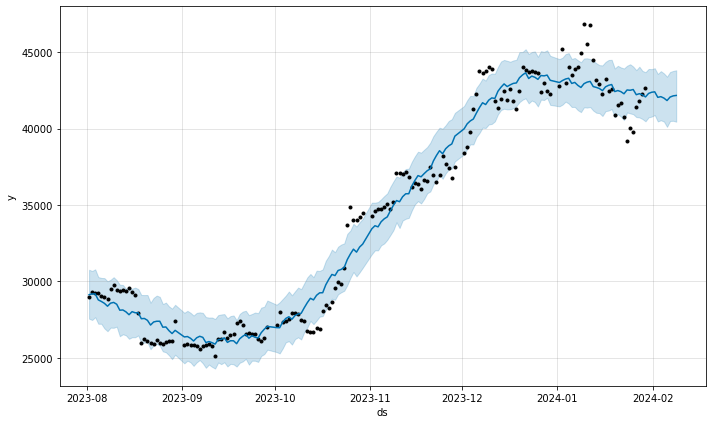

In [30]:
fig1 = model.plot(forecast)

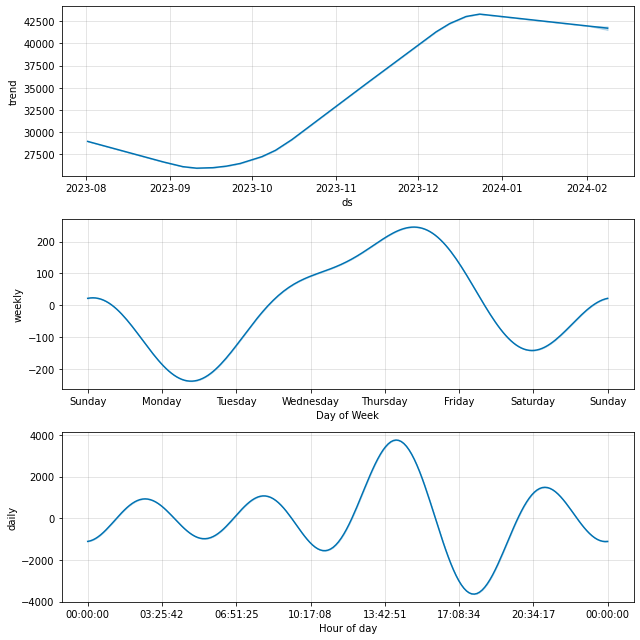

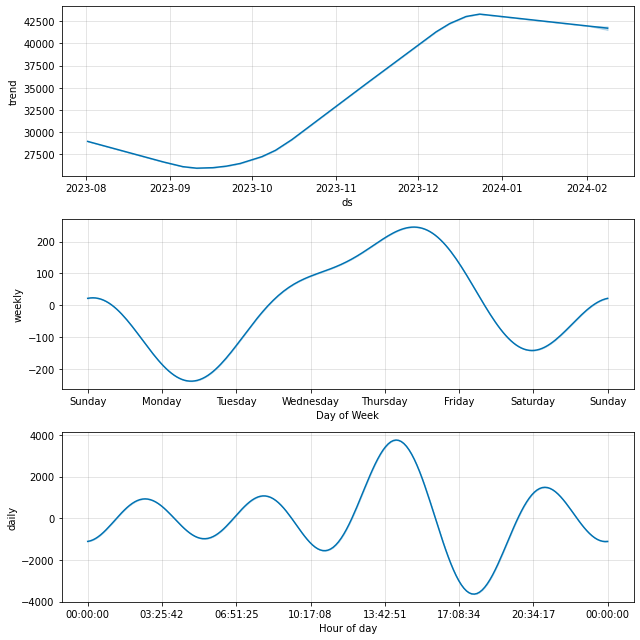

In [31]:
model.plot_components(forecast)

In [17]:
ten_days_after = predicted['yhat'].iloc[9]
one_days_after = predicted['yhat'].iloc[0]
percentage_change = ((ten_days_after - one_days_after) / one_days_after) * 100

In [18]:
percentage_change

-0.30949794466819885

In [34]:
model.history

,ds,y,floor,t,y_scaled
0,2023-08-01 16:00:08.192,28951.7,0.0,0.000000,0.617761
1,2023-08-02 15:59:44.640,29324.0,0.0,0.005523,0.625705
2,2023-08-03 15:59:21.088,29258.6,0.0,0.011047,0.624310
3,2023-08-04 15:58:57.536,29272.0,0.0,0.016570,0.624596
4,2023-08-05 16:00:45.056,29040.0,0.0,0.022102,0.619646
...,...,...,...,...,...
167,2024-01-25 16:00:33.792,39801.1,0.0,0.977906,0.849262
168,2024-01-26 16:00:10.240,41418.1,0.0,0.983430,0.883765
169,2024-01-27 15:59:46.688,41822.0,0.0,0.988953,0.892384
170,2024-01-28 15:59:23.136,42260.3,0.0,0.994477,0.901736


In [33]:
model.params

OrderedDict([('lp__', array([[491.989]])),
             ('k', array([[-0.323969]])),
             ('m', array([[0.617302]])),
             ('delta',
              array([[-9.23482e-09, -2.76645e-09, -1.36153e-08,  4.94273e-04,
                       3.73403e-02,  1.55628e-01,  1.65816e-01,  1.00950e-01,
                       9.44547e-02,  1.41442e-01,  1.82720e-01,  2.20940e-01,
                       1.19464e-01,  6.71004e-09, -2.07378e-08, -1.83748e-05,
                      -1.11626e-02, -2.42315e-03, -9.72878e-09,  8.66791e-09,
                      -3.04933e-09, -1.58180e-01, -2.10628e-01, -3.02588e-01,
                      -3.40934e-01]])),
             ('sigma_obs', array([[0.0265544]])),
             ('beta',
              array([[ 0.00065258,  0.00340979, -0.00070732,  0.00184281,  0.0014159 ,
                      -0.00073598,  0.00365726, -0.00820143,  0.00971123,  0.0150189 ,
                      -0.026793  ,  0.00084622,  0.0171948 , -0.0313221 ]])),
             ('tren

In [43]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [52]:
df_cv = cross_validation(model, initial = '100 days', period = '10 days', horizon = '1 days')
df_cv

  0%|          | 0/8 [00:00<?, ?it/s]

12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing
12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing
12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing
12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing
12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing
12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing
12:28:29 - cmdstanpy - INFO - Chain [1] start processing
12:28:29 - cmdstanpy - INFO - Chain [1] done processing
12:28:29 - cmdstanpy - INFO - Chain [1] start processing
12:28:29 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-11-18 16:01:02.464,38408.781702,37033.377642,39663.744002,36665.8,2023-11-18 15:58:56.512
1,2023-11-28 15:59:18.016,38330.164809,37256.324570,39484.274072,37517.6,2023-11-28 15:58:56.512
2,2023-12-08 15:59:44.640,41223.875803,39875.920629,42586.419970,43758.7,2023-12-08 15:58:56.512
3,2023-12-18 16:00:11.264,43498.154109,42069.948881,44823.182049,41268.9,2023-12-18 15:58:56.512
4,2023-12-28 16:00:37.888,45116.820792,43656.801138,46568.497565,42445.2,2023-12-28 15:58:56.512
5,2024-01-07 16:01:04.512,44594.626303,43206.489822,46068.824574,44048.1,2024-01-07 15:58:56.512
6,2024-01-17 15:59:20.064,45185.228482,43700.325307,46637.717015,42476.5,2024-01-17 15:58:56.512
7,2024-01-18 15:58:56.512,45343.761486,43904.141097,46819.924659,42619.1,2024-01-17 15:58:56.512
8,2024-01-28 15:59:23.136,42205.851438,40543.867966,43821.189774,42260.3,2024-01-28 15:58:59.584
9,2024-01-29 15:58:59.584,42048.583408,40368.280003,43593.045673,42641.5,2024-01-28 15:58:59.584


In [54]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 00:00:21.504000,6.602616e+05,812.564809,812.564809,0.021658,0.021658,0.021426,1.0
1,0 days 00:00:23.552000,3.670087e+06,1915.747196,1381.588522,0.032529,0.032529,0.031544,0.5
2,0 days 00:00:48.128000,6.425334e+06,2534.824197,2534.824197,0.057927,0.057927,0.059655,0.0
3,0 days 00:01:14.752000,4.969574e+06,2229.254109,2229.254109,0.054018,0.054018,0.052597,0.0
4,0 days 00:01:41.376000,7.137558e+06,2671.620792,2671.620792,0.062943,0.062943,0.061022,0.0
5,0 days 00:02:05.952000,3.037985e+06,1742.981702,1742.981702,0.047537,0.047537,0.046433,0.0
6,0 days 00:02:08,2.986910e+05,546.526303,546.526303,0.012407,0.012407,0.012331,1.0
7,1 days 00:00:00,3.887665e+06,1971.716295,1658.789039,0.038918,0.038918,0.037976,0.5


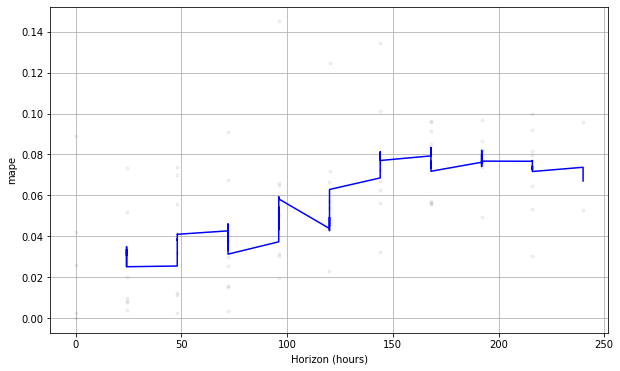

In [47]:
fig = plot_cross_validation_metric(df_cv, metric='mape')